In [30]:
#read captions

def readTextFile(path):
    with open(path,encoding="utf8") as f:
        captions = f.read()
    return captions

In [31]:
captions=readTextFile("finalFR.txt")

In [32]:
captions=captions.split("\n")

In [33]:
# print(len(captions))
print(captions[0])

1000092795.jpg, Two young guys with shaggy hair look at their hands while hanging out in the yard .


### 

In [34]:
first,second=captions[0].split(',')
print(first.split(".")[0])
print(second)



1000092795
 Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [61]:
#dictionary to map each image with list of options it has
descriptions={}


for x in captions:
    
    first,second=x.split(',')
    img_name=first.split(".")[0]
    
    #if image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(second)
    
    
    


In [148]:
descriptions["1283466"]

[' There is a man wearing construction gear standing next to a bulldozer that is picking up rubble and debris .',
 ' A backhoe is on top of a pile of rubble from a demolished building .',
 ' A yellow backhoe is tearing down a brick building .',
 ' Something gets knocked down by a bulldozer .',
 ' A house is being demolished .']

(-0.5, 332.5, 499.5, -0.5)

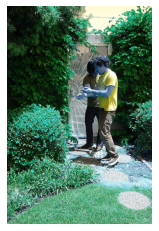

In [38]:
IMG_PATH="flickr30/"
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(IMG_PATH+"1000092795.jpg")
if(img is not None):
    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(np.real(img))
plt.axis("off")

In [39]:
##data cleaning

import pandas as pd
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [40]:
##reduce vocab size-less overfitting and less time to compute remove numbers punctuation and everything which is not an alphabet
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
#     sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence


In [88]:
clean_text("a cat is sitting over house number #64...     ...............")

'a cat is sitting over house number'

In [42]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [43]:
#write the data to a text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [44]:

descriptions=None
with open("descriptions_1.txt",'r') as f:
    descriptions=f.read()
    
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)



In [87]:
print(type(descriptions))

<class 'dict'>


In [46]:
#vocab
vocab=set() #set stores all unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab size:%d"%len(vocab))
    

Vocab size:18078


In [47]:
#total no. of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("total words %d"%len(total_words))

total words 1955183


In [48]:
#filtering words from vocab acc to threshhold 

import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

18078


In [49]:
#sorting acc to freq count

sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])


#filter
threshold=12
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [50]:
print(len(total_words))

4716


In [51]:
comments=readTextFile("finalFR.txt")

In [52]:
comments=comments.split("\n")

In [67]:
with open("train.txt","a") as f:
    for x in comments:
        fi,se=x.split(',')
        f.write(fi+"\n")

In [69]:
train_file_data=readTextFile("train.txt")

In [80]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
#do same for test data


In [90]:
train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [91]:
for k,c in train_descriptions.items():
    for j in range(len(c)):
        c[j]=clean_text(c[j])

In [93]:
train_descriptions["1000092795"]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [96]:
#transfer learning

#1.Image feature Extraction

model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [97]:
 model_new=Model(model.input,model.layers[-2].output)

In [98]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0) #reshape() would have also worked
    
    #normalisation
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


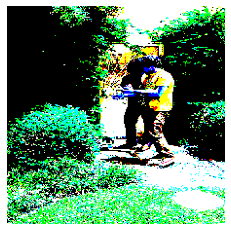

In [103]:
# img=preprocess_img(IMG_PATH+"1000092795.jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

In [112]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector
    

In [113]:
encode_image(IMG_PATH+"1000092795.jpg")

array([0.19759566, 0.18138032, 0.20668261, ..., 0.35860714, 0.64572656,
       0.97927624], dtype=float32)

In [114]:

start=time()
encoding_train={}
#image_id ----->feature_vector extracted from Resnet Image



for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("encoding in progress time step %d "%ix)

end_t=time()
print("total time taken :",end_t-start)

encoding in progress time step 0 
encoding in progress time step 100 
encoding in progress time step 200 
encoding in progress time step 300 
encoding in progress time step 400 
encoding in progress time step 500 
encoding in progress time step 600 
encoding in progress time step 700 
encoding in progress time step 800 
encoding in progress time step 900 
encoding in progress time step 1000 
encoding in progress time step 1100 
encoding in progress time step 1200 
encoding in progress time step 1300 
encoding in progress time step 1400 
encoding in progress time step 1500 
encoding in progress time step 1600 
encoding in progress time step 1700 
encoding in progress time step 1800 
encoding in progress time step 1900 
encoding in progress time step 2000 
encoding in progress time step 2100 
encoding in progress time step 2200 
encoding in progress time step 2300 
encoding in progress time step 2400 
encoding in progress time step 2500 
encoding in progress time step 2600 
encoding in p

encoding in progress time step 21900 
encoding in progress time step 22000 
encoding in progress time step 22100 
encoding in progress time step 22200 
encoding in progress time step 22300 
encoding in progress time step 22400 
encoding in progress time step 22500 
encoding in progress time step 22600 
encoding in progress time step 22700 
encoding in progress time step 22800 
encoding in progress time step 22900 
encoding in progress time step 23000 
encoding in progress time step 23100 
encoding in progress time step 23200 
encoding in progress time step 23300 
encoding in progress time step 23400 
encoding in progress time step 23500 
encoding in progress time step 23600 
encoding in progress time step 23700 
encoding in progress time step 23800 
encoding in progress time step 23900 
encoding in progress time step 24000 
encoding in progress time step 24100 
encoding in progress time step 24200 
encoding in progress time step 24300 
encoding in progress time step 24400 
encoding in 

encoding in progress time step 43500 
encoding in progress time step 43600 
encoding in progress time step 43700 
encoding in progress time step 43800 
encoding in progress time step 43900 
encoding in progress time step 44000 
encoding in progress time step 44100 
encoding in progress time step 44200 
encoding in progress time step 44300 
encoding in progress time step 44400 
encoding in progress time step 44500 
encoding in progress time step 44600 
encoding in progress time step 44700 
encoding in progress time step 44800 
encoding in progress time step 44900 
encoding in progress time step 45000 
encoding in progress time step 45100 
encoding in progress time step 45200 
encoding in progress time step 45300 
encoding in progress time step 45400 
encoding in progress time step 45500 
encoding in progress time step 45600 
encoding in progress time step 45700 
encoding in progress time step 45800 
encoding in progress time step 45900 
encoding in progress time step 46000 
encoding in 

encoding in progress time step 65100 
encoding in progress time step 65200 
encoding in progress time step 65300 
encoding in progress time step 65400 
encoding in progress time step 65500 
encoding in progress time step 65600 
encoding in progress time step 65700 
encoding in progress time step 65800 
encoding in progress time step 65900 
encoding in progress time step 66000 
encoding in progress time step 66100 
encoding in progress time step 66200 
encoding in progress time step 66300 
encoding in progress time step 66400 
encoding in progress time step 66500 
encoding in progress time step 66600 
encoding in progress time step 66700 
encoding in progress time step 66800 
encoding in progress time step 66900 
encoding in progress time step 67000 
encoding in progress time step 67100 
encoding in progress time step 67200 
encoding in progress time step 67300 
encoding in progress time step 67400 
encoding in progress time step 67500 
encoding in progress time step 67600 
encoding in 

encoding in progress time step 86700 
encoding in progress time step 86800 
encoding in progress time step 86900 
encoding in progress time step 87000 
encoding in progress time step 87100 
encoding in progress time step 87200 
encoding in progress time step 87300 
encoding in progress time step 87400 
encoding in progress time step 87500 
encoding in progress time step 87600 
encoding in progress time step 87700 
encoding in progress time step 87800 
encoding in progress time step 87900 
encoding in progress time step 88000 
encoding in progress time step 88100 
encoding in progress time step 88200 
encoding in progress time step 88300 
encoding in progress time step 88400 
encoding in progress time step 88500 
encoding in progress time step 88600 
encoding in progress time step 88700 
encoding in progress time step 88800 
encoding in progress time step 88900 
encoding in progress time step 89000 
encoding in progress time step 89100 
encoding in progress time step 89200 
encoding in 

encoding in progress time step 108100 
encoding in progress time step 108200 
encoding in progress time step 108300 
encoding in progress time step 108400 
encoding in progress time step 108500 
encoding in progress time step 108600 
encoding in progress time step 108700 
encoding in progress time step 108800 
encoding in progress time step 108900 
encoding in progress time step 109000 
encoding in progress time step 109100 
encoding in progress time step 109200 
encoding in progress time step 109300 
encoding in progress time step 109400 
encoding in progress time step 109500 
encoding in progress time step 109600 
encoding in progress time step 109700 
encoding in progress time step 109800 
encoding in progress time step 109900 
encoding in progress time step 110000 
encoding in progress time step 110100 
encoding in progress time step 110200 
encoding in progress time step 110300 
encoding in progress time step 110400 
encoding in progress time step 110500 
encoding in progress time

encoding in progress time step 129200 
encoding in progress time step 129300 
encoding in progress time step 129400 
encoding in progress time step 129500 
encoding in progress time step 129600 
encoding in progress time step 129700 
encoding in progress time step 129800 
encoding in progress time step 129900 
encoding in progress time step 130000 
encoding in progress time step 130100 
encoding in progress time step 130200 
encoding in progress time step 130300 
encoding in progress time step 130400 
encoding in progress time step 130500 
encoding in progress time step 130600 
encoding in progress time step 130700 
encoding in progress time step 130800 
encoding in progress time step 130900 
encoding in progress time step 131000 
encoding in progress time step 131100 
encoding in progress time step 131200 
encoding in progress time step 131300 
encoding in progress time step 131400 
encoding in progress time step 131500 
encoding in progress time step 131600 
encoding in progress time

encoding in progress time step 150300 
encoding in progress time step 150400 
encoding in progress time step 150500 
encoding in progress time step 150600 
encoding in progress time step 150700 
encoding in progress time step 150800 
encoding in progress time step 150900 
encoding in progress time step 151000 
encoding in progress time step 151100 
encoding in progress time step 151200 
encoding in progress time step 151300 
encoding in progress time step 151400 
encoding in progress time step 151500 
encoding in progress time step 151600 
encoding in progress time step 151700 
encoding in progress time step 151800 
encoding in progress time step 151900 
encoding in progress time step 152000 
encoding in progress time step 152100 
encoding in progress time step 152200 
encoding in progress time step 152300 
encoding in progress time step 152400 
encoding in progress time step 152500 
encoding in progress time step 152600 
encoding in progress time step 152700 
encoding in progress time

In [115]:
#store everything to the disk 


with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [117]:
#encode test data also and store in pickle file

In [119]:
#preprocessing captions
word_to_idx={}
idx_to_word={}






for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [126]:
word_to_idx["dog"]
print(len(idx_to_word))

4716


In [129]:
#two special words start seq and end seq 
idx_to_word[4717]='startseq'
word_to_idx['startseq']=4717



idx_to_word[4718]='endseq'
word_to_idx['endseq']=4718

vocab_size=len(word_to_idx)+1
print("Vocab Size",vocab_size)

Vocab Size 4719


In [130]:
max_len=0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

80


In [179]:
## Data loader(Generator)

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    
    
    X1,X2,y=[],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo=encoding_train[key]
            
            for desc in desc_list:
                
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    
                    #0 denotes padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y=[],[],[]
                    n=0
                    
                    
                    


In [137]:
f=open("glove.6B.50d.txt",encoding='utf8')

In [140]:
#Word Embeddings

embedding_index={}


for line in f:
    values=line.split()
   

    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    

    
    

In [142]:
f.close()

In [153]:
embedding_index['']

array([-1.4835  , -0.92018 , -0.094818,  0.32327 ,  0.34985 , -0.54979 ,
        1.5909  , -0.38319 ,  0.19379 ,  0.085752,  0.27349 ,  0.53244 ,
        0.29914 ,  0.20451 , -0.17663 , -0.66484 , -0.49235 ,  0.68055 ,
        1.2743  ,  1.1548  , -0.42803 ,  0.2103  ,  0.41392 , -1.1604  ,
       -0.2385  ,  0.49756 ,  0.38689 , -0.90407 , -0.061603,  0.38851 ,
       -1.0161  , -0.23155 ,  0.43162 ,  0.50227 , -0.46488 ,  1.2821  ,
       -0.25164 , -0.023098,  0.432   ,  0.44346 , -0.65569 ,  0.011187,
        0.5443  , -0.19708 ,  0.97244 ,  0.60664 ,  0.030533,  0.24069 ,
       -0.95055 ,  0.086419])

In [143]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
            
    return matrix
    

In [155]:
embedding_matrix=get_embedding_matrix()

embedding_matrix.shape


(4719, 50)

In [147]:
# embedding_matrix[4718]

In [158]:
#Model Architecture

input_img_features=Input(shape=(2048,))

inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)



In [159]:
#captions as input

input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)


In [160]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#combined model

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)


In [162]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 50)       235950      ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [163]:
#preinitialize embedding layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False


In [164]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [173]:
#training of model

epochs=30
batch_size=3
steps=len(train_descriptions)//batch_size


In [174]:
def train():
    
    for i in range(epochs):
        generator =data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')

In [180]:
train()

C:\Users\Tushar\AppData\Local\Temp/ipykernel_15844/4022939330.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


10594/10594 [==============================] - 28687s 3s/step - loss: 3.7881


c:\users\tushar\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


  172/10594 [..............................] - ETA: 1:23:05 - loss: 3.4117

KeyboardInterrupt: 